In [1]:
import polars as pl
import numpy as np
import pandas as pd
import altair as alt
import os
import wget
import zipfile

from os.path import exists
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [2]:
beans = "./DryBeanDataset/Dry_Bean_Dataset.xlsx"
base = "https://archive.ics.uci.edu/ml/machine-learning-databases/"
dataset_number = "00602"

In [3]:
if not exists(beans):
    filename = "DryBeanDataset.zip"
    url = f"{base}{dataset_number}/{filename}"
    wget.download(url)
    with zipfile.ZipFile(filename, "r") as zip_ref:
        zip_ref.extractall('./')
    os.remove(filename)

In [4]:
bean_df = pl.read_excel("./DryBeanDataset/Dry_Bean_Dataset.xlsx")
bean_df = bean_df.to_pandas()
le = LabelEncoder()
bean_df["Class"] = le.fit_transform(bean_df["Class"])

In [5]:
y = pl.Series(bean_df["Class"])
X = pl.DataFrame(bean_df.drop("Class", axis=1))
X_train, X_rest1, y_train, y_rest1 = train_test_split(X, y, train_size=10000, random_state=2)
X_test, X_rest2, y_test, y_rest2 = train_test_split(X_rest1, y_rest1, train_size=1000, random_state=42)
X_calib, X_new, y_calib, y_new = train_test_split(X_rest2, y_rest2, train_size=1000, random_state=42)

In [6]:
model = GaussianNB().fit(X_train, y_train)
y_pred = model.predict(X_test)
print((pl.Series(y_pred) == y_test).mean())
print(le.classes_)

0.758
['BARBUNYA' 'BOMBAY' 'CALI' 'DERMASON' 'HOROZ' 'SEKER' 'SIRA']


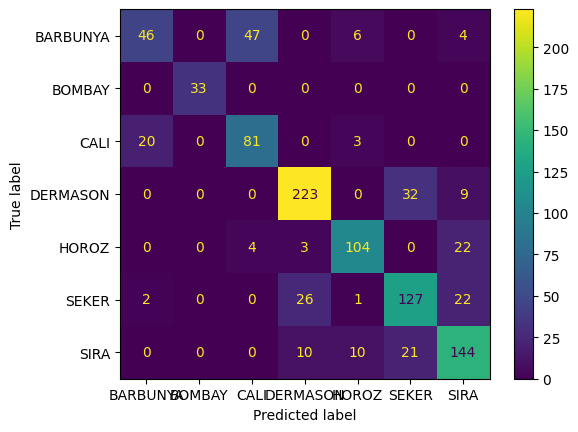

In [7]:
cm = confusion_matrix(y_test, y_pred)
conf = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
conf.plot()

In [8]:
predictions = model.predict_proba(X_calib)
high_prob_predictions = np.amax(predictions, axis=1)
high_p_beans = np.where(high_prob_predictions >= 0.95)
its_a_match = pl.DataFrame().with_columns(match=(pl.Series(model.predict(X_calib)) == pl.Series(y_calib))).with_row_index()
max_acc_beans = its_a_match.filter(pl.col("index").is_in(high_p_beans[0]))
coverage = round(max_acc_beans["match"].mean(), 3)
coverage

0.896

In [11]:
# x test could also be used since data is not seen by training, and it comes from the same distribution not violating the exchangability
n = len(X_calib)
predictions = model.predict_proba(X_calib)
prob_true_class = predictions[np.arange(n), y_calib]
scores = 1- prob_true_class
alpha = 0.05 # to match 95 % prediction level
# sample size correction to 0.951
q_level = np.ceil((n+1)*(1-alpha))/n

In [12]:
# quantile calculation to know where to cutoff values so that you are sure the right
# class is there 95 % of the time
qhat = np.quantile(scores, q_level, method="higher")
df_non_conf = pl.DataFrame().with_columns(non_conformity_score= 1 - prob_true_class)
df_non_conf.plot.bar(
    x=alt.X("non_conformity_score").bin(maxbins=20),
    y='count()'

).properties(width=500)

alt.Chart(...)

In [13]:
#qhat comes from calibration dataset so this means we have to split test set, to see how
# the calibration with the quantiles work on the test set
prediction_sets = (1-model.predict_proba(X_new) <= qhat)

In [14]:
for i in range(3):
    print(le.classes_[prediction_sets[i]])
    
print(prediction_sets)
#was übrig bleibt sind sicherere vorhergesagte prediction sets

['DERMASON']
['DERMASON']
['DERMASON' 'SEKER']
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False  True False]
 ...
 [False False False ... False False False]
 [False False False ...  True False False]
 [False False False ...  True False  True]]


In [16]:
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score
from mapie.metrics import classification_coverage_score_v2
from mapie.metrics import classification_mean_width_score

In [17]:
cp = MapieClassifier(estimator=model, cv="prefit", method="score")

In [18]:
cp.fit(X_calib, y_calib)

MapieClassifier(cv='prefit', estimator=GaussianNB(), method='score')

In [20]:
y_pred, y_set = cp.predict(X_new, alpha=0.05)

In [22]:
y_set = np.squeeze(y_set)

In [24]:
for i in range(5):
    print(le.classes_[y_set[i]])

['DERMASON']
['DERMASON']
['DERMASON' 'SEKER']
['DERMASON']
['DERMASON' 'SEKER']


In [27]:
# first count the number of classes per bean
set_sizes = y_set.sum(axis=1)
set_sizes

array([1, 1, 2, ..., 1, 1, 2])

In [34]:
print(pl.Series(set_sizes).value_counts())

shape: (4, 2)
┌─────┬───────┐
│     ┆ count │
│ --- ┆ ---   │
│ i64 ┆ u32   │
╞═════╪═══════╡
│ 1   ┆ 506   │
│ 3   ┆ 233   │
│ 4   ┆ 1     │
│ 2   ┆ 871   │
└─────┴───────┘


In [ ]:
# if we make the alpha smaller, ofc we have then only high probabilty true classes

In [35]:
y_pred, y_set = cp.predict(X_new, alpha=0.01)

In [36]:
y_set = np.squeeze(y_set)

In [37]:
for i in range(4):
    print(le.classes_[y_set[i]])

['DERMASON']
['DERMASON' 'SEKER']
['DERMASON' 'SEKER']
['DERMASON']


In [38]:
set_sizes = y_set.sum(axis=1)
print(pl.Series(set_sizes).value_counts())

shape: (5, 2)
┌─────┬───────┐
│     ┆ count │
│ --- ┆ ---   │
│ i64 ┆ u32   │
╞═════╪═══════╡
│ 1   ┆ 222   │
│ 2   ┆ 369   │
│ 4   ┆ 241   │
│ 5   ┆ 1     │
│ 3   ┆ 778   │
└─────┴───────┘


In [ ]:
# more coverage of beans, means 